# Amazon Reviews

The goal is to create a model to algorithmically predict if a review is positive or negative just based on its text. Try to see how these reviews compare across categories. Does a review classification model for one category work for another?

### Plan
1. Will use a Bernoulli Naive Bayes model since its a binary classifier and just trying to determing positive or not positive.
2. The key metric will be accuracy. Satisficing metrics will be precision, recall and F1.
3. Use mainly Naive Bayes, but check against another one Random Forest
4. Will have to look at dealing with sampling. Since it will be unbalanced.
5. Will perform feature engineer to find the best words associated with positive rating, and negative ratings. (Will do Simple NLP)
6. Will then do a select k best to select the best features.
7. Will perform a grid search to find the best parameters for the model, and do some hyper parameter searching.
8. Then see if we can improve the model with bagging and boosting.

## Naive Bayes

Bayes Theorem covers the probabilistic relationship between multiple variables, and specifically allows us to define one conditional in terms of the underlying probabilities and the inverse condition. Specifically, it can be defined as:

$$P(y|x) = P(y)P(x|y)/P(x)$$

In English this reads as "the probability of y given x equals the probability of y times the probability of x given y divided by the probability of x."


This theorem can be extended to when x is a vector (containing the multiple x variables used as inputs for the model) to:

$$P(y|x_1,...,x_n) = P(y)P(x_1,...,x_n|y)/P(x_1,...,x_n)$$

This explains the relationship of an outcome to a vector of conditions rather than to a single other event. Recall that this can be read as the probability of y, in the case of our model the categorical outcome we’re interested in, given a set of observations is equal to the probability of that set of observations given y divided by the probability of that set of outcomes.


#### Assumptions
1. Assume the variables are independent.
2. Wont handle new data, so the training set needs to be actually representative of what going to see. So any new words wont be handled.

### Conclusion

After lot of feature engineering and model comparisons, the review text alone isnt conducive to accurately predicting if its a positive review or not. If we want to focus on one class, then we could skew the dataset to reflect that.

Additionally, I created a Docker workflow system, where I can try things out locally, and since NLP libraries were taking a while. I simply spun up a more powerul EC2 instance, and was able to iterate on the analysis a lot quicker.

In [73]:
########### Imports #################
# Basic Imports
import numpy as np
import pandas as pd
import scipy
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Infrastructure
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.utils import resample
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import boto3
import io

# Language processing
import nltk
#nltk.download()
import spacy

# Speed up tokenizing by disabling objects in the pipeline
nlp = spacy.load('en', disable=['parser', 'tagger','ner','textcat'])
#nlp = spacy.load('en')

# Model
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
########## Bring in Data ###############

#Connect with S3
client = boto3.client('s3')
obj = client.get_object(Bucket='data-science-project-data', Key='Amazon_Reviews/reviews_Sports_and_Outdoors_5.json')

#Converting json to a format that can be used
json_data = obj['Body'].read().decode('utf-8')

# Pandas Read
data = pd.read_json(json_data, lines=True)
data.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1881509818,"[0, 0]",5,This came in on time and I am veru happy with ...,"01 26, 2014",AIXZKN4ACSKI,David Briner,Woks very good,1390694400
1,1881509818,"[1, 1]",5,I had a factory Glock tool that I was using fo...,"02 2, 2012",A1L5P841VIO02V,Jason A. Kramer,Works as well as the factory tool,1328140800
2,1881509818,"[2, 2]",4,If you don't have a 3/32 punch or would like t...,"02 28, 2012",AB2W04NI4OEAD,J. Fernald,"It's a punch, that's all.",1330387200
3,1881509818,"[0, 0]",4,This works no better than any 3/32 punch you w...,"02 5, 2012",A148SVSWKTJKU6,"Jusitn A. Watts ""Maverick9614""",It's a punch with a Glock logo.,1328400000
4,1881509818,"[0, 0]",4,I purchased this thinking maybe I need a speci...,"04 23, 2013",AAAWJ6LW9WMOO,Material Man,"Ok,tool does what a regular punch does.",1366675200


In [4]:
data['overall'].value_counts()

5    188208
4     64809
3     24071
2     10204
1      9045
Name: overall, dtype: int64

In [5]:
##### Create Interested Dataset ###########
df = data[['reviewText']]

# Create Outcome variable of 
df['Positive?'] = np.where(data['overall']>=4.0,1,0)
df.head()

,reviewText,Positive?
0,This came in on time and I am veru happy with ...,1
1,I had a factory Glock tool that I was using fo...,1
2,If you don't have a 3/32 punch or would like t...,1
3,This works no better than any 3/32 punch you w...,1
4,I purchased this thinking maybe I need a speci...,1


In [6]:
# The Dataset is very unbalanced. So have to look out for this. 
df['Positive?'].value_counts()

1    253017
0     43320
Name: Positive?, dtype: int64

## Class Balancing

In [7]:
#The dataset isnt balanced, so lets undersample the Positive
df_positive = df[df['Positive?']==1]
df_negative = df[df['Positive?']==0]

# Downsample Positive ratings
df_positive_downsamples = resample(df_positive, 
                                 replace=False,    # sample without replacement
                                 n_samples=43320,     # to match minority class
                                 random_state=123) # reproducible results

# Create new dataframe with resampled
df_downsampled = pd.concat([df_positive_downsamples, df_negative])

In [8]:
#Check the class split
df_downsampled['Positive?'].value_counts()

1    43320
0    43320
Name: Positive?, dtype: int64

## Feature Engineering

In [9]:
# Create function to remove the white space
def clean_data(text):
    return ' '.join(text.split())

In [10]:
# Remove white space
df_downsampled['Clean Text'] = df_downsampled['reviewText'].apply(lambda x: clean_data(x))

In [11]:
# Create tokens, which splits out even the punctuation.

# Create function to do this for every review
def create_tokens(text):
    return nlp(text)

In [12]:
start_time = time.time()
df_downsampled['Tokens'] = df_downsampled['Clean Text'].apply(lambda x: create_tokens(x))
print("--- %s seconds ---" % (time.time() - start_time))

--- 27.104275941848755 seconds ---


In [13]:
df_downsampled.head()

,reviewText,Positive?,Clean Text,Tokens
88844,"A wee bit pricy, but does the job... no squeak...",1,"A wee bit pricy, but does the job... no squeak...","(A, wee, bit, pricy, ,, but, does, the, job, ...."
183720,"These are nice tights, very well made. But th...",1,"These are nice tights, very well made. But the...","(These, are, nice, tights, ,, very, well, made..."
209408,Never know when you will reach a place one can...,1,Never know when you will reach a place one can...,"(Never, know, when, you, will, reach, a, place..."
249451,"It fit nicely on my M4, it arrived 2 days afte...",1,"It fit nicely on my M4, it arrived 2 days afte...","(It, fit, nicely, on, my, M4, ,, it, arrived, ..."
75086,"Like the video review said, this knife comes f...",1,"Like the video review said, this knife comes f...","(Like, the, video, review, said, ,, this, knif..."


#### Bag of Words

We will do bag of words. We will exclude stopwords and punctuation. In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 2000 most common words for each text.

In [14]:
df_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86640 entries, 88844 to 296156
Data columns (total 4 columns):
reviewText    86640 non-null object
Positive?     86640 non-null int64
Clean Text    86640 non-null object
Tokens        86640 non-null object
dtypes: int64(1), object(3)
memory usage: 3.3+ MB


In [15]:
# Create to create a bag of words. First have to create bag for all text for positive
positive = df_downsampled[df_downsampled['Positive?']==1]
negative = df_downsampled[df_downsampled['Positive?']==0]

start_time = time.time()
# String together all reviews to create a tokenized documents for positive and negative
positive_doc = nlp(positive['Clean Text'].str.cat(sep=' '))
negative_doc = nlp(negative['Clean Text'].str.cat(sep=' '))
print("--- %s seconds ---" % (time.time() - start_time))

--- 20.48040246963501 seconds ---


In [63]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(100)]



# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(dataframe, common_words, start_time):
    
    # Scaffold the data frame and initialize counts to zero.
    output = pd.DataFrame(columns=common_words)
    output['Positive?'] = dataframe['Positive?']
    output.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each row.
    for i, row in enumerate(dataframe['Tokens']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in row
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            #Need to handle the key error if not found.
            try:
                output.loc[i, word] += 1
            except:
                pass
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 10000 == 0:
            print("Processing row {}".format(i))
            print("--- %s seconds ---" % (time.time() - start_time))
            
    return output

In [64]:
# Set up the bags.
positive_words = bag_of_words(positive_doc)
negative_words = bag_of_words(negative_doc)
start_time = time.time()
# Combine bags to create a set of unique words.
common_words = set(positive_words + negative_words)

In [66]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(df_downsampled, common_words, time.time())
word_counts.head()

Processing row 0
--- 4.230454444885254 seconds ---
Processing row 10000
--- 19.124003648757935 seconds ---
Processing row 20000
--- 33.95120310783386 seconds ---
Processing row 30000
--- 49.54160761833191 seconds ---
Processing row 40000
--- 64.66638088226318 seconds ---
Processing row 50000
--- 80.8839967250824 seconds ---
Processing row 60000
--- 97.5363941192627 seconds ---
Processing row 70000
--- 114.7247109413147 seconds ---
Processing row 80000
--- 131.4802360534668 seconds ---


,large,fit,If,pretty,way,work,nice,-PRON-,find,strap,...,right,love,time,know,hard,You,take,bad,wear,Positive?
88844,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
183720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
209408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
249451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
75086,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
y = word_counts['Positive?']
#X = word_counts[~word_counts['Positive?']]
X = word_counts.loc[:, word_counts.columns != 'Positive?']

## Select Best Features

In [67]:
start_time = time.time()
selector = SelectKBest(f_classif, k=50)
selector.fit(X,y)

idxs_selected = selector.get_support(indices=True)
best_features = X[X.columns[idxs_selected]]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7920613288879395 seconds ---


In [68]:
best_features.head()

,car,wrist,allow,kit,foot,step,All,handy,warm,post,...,In,8,mean,center,20,deal,excellent,bike,tube,stuff
88844,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
209408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
249451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


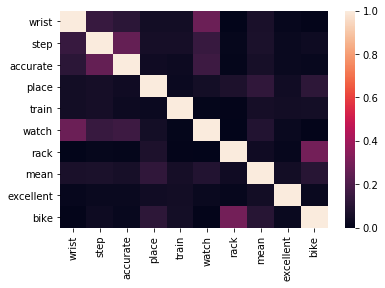

In [49]:
#Only did this when the number of best features is low
sns.heatmap(best_features.corr())

In [69]:
#Pull out Train, Dev and Test
X_train, X_dev_test, y_train, y_dev_test = train_test_split(best_features,y,test_size=0.4)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev_test,y_dev_test,test_size=0.5)

### Build Model

#### Naive Bayes

In [70]:
start_time = time.time()
parameters = {
    
               'alpha': [0.5]
              }

bnb = BernoulliNB(fit_prior=False)

grid = GridSearchCV(bnb, parameters, scoring='accuracy', cv=5, verbose=0)
#Fit the Data
grid.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.25769758224487305 seconds ---


In [71]:
grid.best_score_

0.5026738996614343

In [72]:
grid.score(X_dev, y_dev)

0.5065212373037857

Bagging to Improve

In [56]:
bnb = BernoulliNB(fit_prior=False, alpha=0.5)
bagging = BaggingClassifier(bnb, n_jobs=15)

bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None, fit_prior=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=15, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [57]:
bagging.score(X_test, y_test)

0.5055978762696214

Boosting to Improve

In [59]:
boosting = AdaBoostClassifier(bnb, n_estimators=100)
boosting.fit(X_train, y_train)
print(boosting.score(X_test, y_test))

0.505713296398892
             precision    recall  f1-score   support

          0       0.53      0.05      0.09      8611
          1       0.50      0.96      0.66      8717

avg / total       0.52      0.51      0.38     17328



#### Random Forest

In [74]:
start_time = time.time()
parameters = {
    
               'max_features': [2, 5, 'auto']
              }
rfc = RandomForestClassifier()

grid = GridSearchCV(rfc, parameters, scoring='accuracy', cv=5, verbose=0)
#Fit the Data
grid.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))


--- 6.6581761837005615 seconds ---


In [75]:
grid.score(X_test, y_test)

0.5031163434903048